# Smart Logistics & Supply Chain Analysis
## 1. Initial Data Exploration

### Dataset Overview
This notebook analyzes the **Smart Logistics Dataset**, which contains real-time tracking of 10 delivery trucks. The data integrates logistical metrics (delays, asset utilization), environmental sensors (temperature, humidity), and consumer behavior data (transaction amounts, demand forecast).

**Source:** Ziya. (2024). *Smart Logistics & Supply Chain Dataset* [Kaggle](https://www.kaggle.com/datasets/ziya07/smart-logistics-supply-chain-dataset).

_This notebook was developed by [Alexandre Andrade](https://github.com/alexandrade1978) as part of the Ironhack Data Science & Machine Learning Bootcamp (January 2026)._

---

### Data Dictionary
| Column | Description |
| :--- | :--- |
| **Timestamp** | Date and time of the record |
| **Asset_ID** | Unique identifier for the truck (Truck_1 to Truck_10) |
| **Latitude / Longitude** | Geographic coordinates of the asset |
| **Inventory_Level** | Current stock being transported |
| **Shipment_Status** | Current state (In Transit, Delayed, Delivered) |
| **Temperature / Humidity** | Environmental conditions during transport |
| **Traffic_Status** | Road conditions (Clear, Heavy, Detour) |
| **Waiting_Time** | Idle time in minutes |
| **User_Transaction_Amount** | Monetary amount associated with user transactions |
| **User_Purchase_Frequency** | Frequency of purchases made by the user |
| **Logistics_Delay_Reason** | Primary cause of delay (Weather, Traffic, Mechanical) |
| **Asset_Utilization** | Efficiency percentage of the asset's capacity |
| **Demand_Forecast** | Predicted demand for the logistics services in the coming period |
| **Logistics_Delay** | Binary target (1 = Delayed, 0 = On Time) |

---

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as mcolors
import scipy.stats as stats
from statsmodels.stats.proportion import proportions_ztest
from statsmodels.stats.proportion import proportion_confint

%matplotlib inline
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [2]:
data = pd.read_csv("../data/smart_logistics_dataset.csv")
df = data.copy()

### 1.1 First Look at the Raw Data
We will display the first few rows of the dataset to understand its structure, identify the initial columns, and observe the formatting of timestamps and categorical labels.

---

In [3]:
df.head()

,Timestamp,Asset_ID,Latitude,Longitude,Inventory_Level,Shipment_Status,Temperature,Humidity,Traffic_Status,Waiting_Time,User_Transaction_Amount,User_Purchase_Frequency,Logistics_Delay_Reason,Asset_Utilization,Demand_Forecast,Logistics_Delay
0,2024-03-20 00:11:14,Truck_7,-65.74,11.25,390,Delayed,27.00,67.80,Detour,38,320,4,NaN,60.10,285,1
1,2024-10-30 07:53:51,Truck_6,22.27,-131.71,491,In Transit,22.50,54.30,Heavy,16,439,7,Weather,80.90,174,1
2,2024-07-29 18:42:48,Truck_10,54.92,79.55,190,In Transit,25.20,62.20,Detour,34,355,3,NaN,99.20,260,0
3,2024-10-28 00:50:54,Truck_9,42.39,-1.48,330,Delivered,25.40,52.30,Heavy,37,227,5,Traffic,97.40,160,1
4,2024-09-27 15:52:58,Truck_7,-65.85,47.95,480,Delayed,20.50,57.20,Clear,56,197,6,NaN,71.60,270,1


### 1.2 Initial Observations from the Data Sample

After displaying the first 5 rows of the dataset, several key characteristics can be identified:

* **Data Structure:** The dataset consists of a mix of numerical (floats and integers), categorical (strings), and temporal data.
* **Temporal Information:** The `Timestamp` column is currently in string format (object), representing specific dates and times in 2024.
* **Geographical Context:** `Latitude` and `Longitude` provide the exact positioning of the assets (trucks) at the time of recording.
* **Categorical Features:** * `Shipment_Status` includes states such as *Delayed*, *In Transit*, and *Delivered*.
    * `Traffic_Status` records road conditions like *Detour*, *Heavy*, and *Clear*.
    * `Logistics_Delay_Reason` contains specific causes (e.g., *Weather*, *Traffic*), but also shows **NaN (missing values)**, particularly when the shipment might not be delayed or the reason wasn't logged.
* **Target Variable:** The `Logistics_Delay` column is a binary indicator (1 for delay, 0 for no delay), which will likely be our primary variable for analysis and prediction.
* **Asset Variety:** Different trucks (e.g., `Truck_7`, `Truck_6`, `Truck_10`) are represented, suggesting we can track performance per individual asset.

## 2. Data Cleaning & Pre-processing

In this section, we will prepare the dataset for analysis by:
1. **Handling Missing Values:** Specifically in the `Logistics_Delay_Reason` column.
2. **Dropping Irrelevant Columns:** If any columns are deemed unnecessary for analysis.
3. **Exploratory Inspection:** Checking the distribution of numerical and categorical variables.

In [4]:
# 1. Inspecting data types and missing values
print("--- Dataset Info ---")
print(df.info())

print("\n--- Missing Values Count ---")
print(df.isnull().sum())

--- Dataset Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Timestamp                1000 non-null   object 
 1   Asset_ID                 1000 non-null   object 
 2   Latitude                 1000 non-null   float64
 3   Longitude                1000 non-null   float64
 4   Inventory_Level          1000 non-null   int64  
 5   Shipment_Status          1000 non-null   object 
 6   Temperature              1000 non-null   float64
 7   Humidity                 1000 non-null   float64
 8   Traffic_Status           1000 non-null   object 
 9   Waiting_Time             1000 non-null   int64  
 10  User_Transaction_Amount  1000 non-null   int64  
 11  User_Purchase_Frequency  1000 non-null   int64  
 12  Logistics_Delay_Reason   737 non-null    object 
 13  Asset_Utilization        1000 non-null   float64
 14  Dema

### 2.1 Handling Missing Values in Logistics_Delay_Reason
During the initial inspection, we observed that the Logistics_Delay_Reason column contains several null values (NaN). Our strategy is to impute these with the string 'None' instead of dropping them.

#### Rationale for this decision:

 - The "Unreported" Reality: In logistics, a delay often occurs without a direct reason being logged. Managers may not receive real-time feedback for every incident. Many delays result from factors like a subcontractor’s lack of capacity, driver indisposition, or even self-preservation—where subcontractors avoid reporting the true cause of a delay to protect their performance metrics. Therefore, a missing reason is, in itself, a data point that justifies the occurrence of a delay.

 - Decoupling Conditions from Outcomes: Conversely, the presence of a "negative" condition (e.g., Heavy Traffic or Bad Weather) does not guarantee a delay. A truck may navigate through heavy traffic better than expected, or a company might deploy an extra driver to compensate for bad weather, ensuring the delivery is completed on time despite favorable conditions for a delay.

 - Data Integrity: By categorizing missing entries as 'None', we preserve the full context of the dataset. This allows us to analyze the gap between theoretical risks (the "reasons") and actual operational outcomes (Logistics_Delay), capturing the complexity of subcontracted logistics networks.

In [5]:
#  Handling Missing Values
df['Logistics_Delay_Reason'] = df['Logistics_Delay_Reason'].fillna('None')

### 2.2 Dropping Irrelevant Columns: If any columns are deemed unnecessary for analysis.

In [6]:
cols_to_drop = [
    'Timestamp',
    'Latitude', 
    'Longitude', 
    'Inventory_Level',
    'Shipment_Status',
    'Temperature',
    'Humidity',
    'User_Transaction_Amount', 
    'User_Purchase_Frequency',
    'Demand_Forecast'
]   

# Remove irrelevant columns
df = df.drop(columns=cols_to_drop)

# Check the new state of the dataset
print(f"Remaining columns: {df.columns.tolist()}")

Remaining columns: ['Asset_ID', 'Traffic_Status', 'Waiting_Time', 'Logistics_Delay_Reason', 'Asset_Utilization', 'Logistics_Delay']


### 2.3 Exploratory Inspection of numerical and categorical variables.

In [7]:
# Show descriptive statistics for numerical columns
df.describe()

,Waiting_Time,Asset_Utilization,Logistics_Delay
count,1000.00,1000.00,1000.00
mean,35.06,79.60,0.57
std,14.48,11.63,0.50
min,10.00,60.00,0.00
25%,23.00,69.47,0.00
50%,35.00,79.25,1.00
75%,49.00,89.43,1.00
max,60.00,100.00,1.00


In [8]:
df.describe(include=['object'])

,Asset_ID,Traffic_Status,Logistics_Delay_Reason
count,1000,1000,1000
unique,10,3,4
top,Truck_8,Detour,Weather
freq,109,345,267


## 3. Impact of Operational Factors on Delivery Delays
In this section, we analyze how different operational variables influence the likelihood of a delivery being delayed. We will focus on:

 - Operational Reasons: Analyzing the impact of reported reasons (Weather, Mechanical, etc.) versus actual outcomes.

 - Waiting Time & Utilization: Assessing if idle time or high asset capacity usage triggers delays.

 - Traffic Status: How road conditions correlate with delays.
 
 - Utilization Intensity vs. Mechanical Reliability

### 3.1 Univariate Analysis: Operational Overview
#### 3.1.1 Descriptive Distribution of Delivery Outcomes

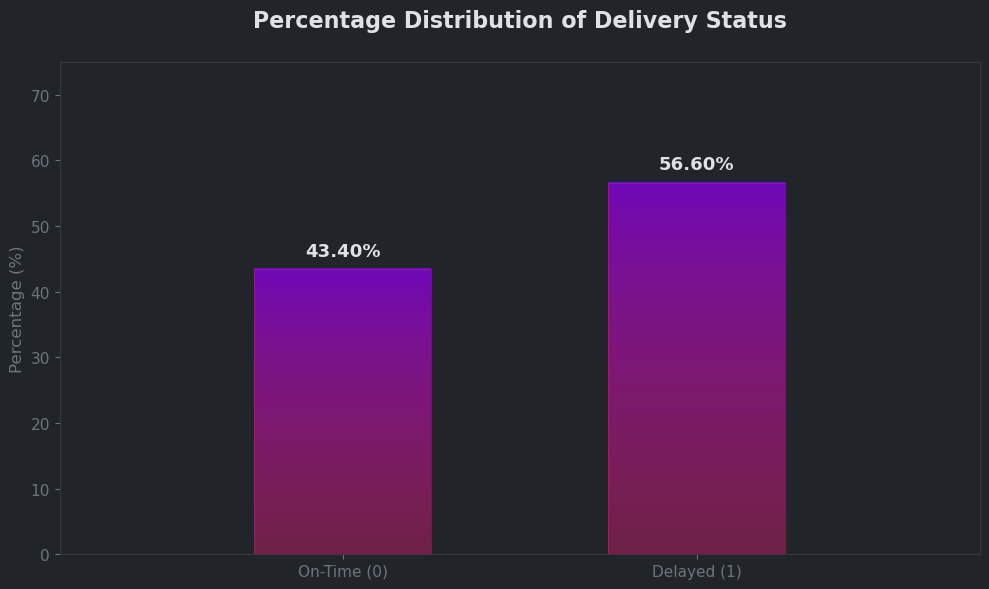

In [9]:
delay_counts = df['Logistics_Delay'].value_counts(normalize=True) * 100
delay_df = delay_counts.reset_index().sort_values('Logistics_Delay')
delay_df.columns = ['Status', 'Percentage']

labels = ['On-Time (0)', 'Delayed (1)']
values = delay_df['Percentage'].values
xticks = np.arange(len(labels))

custom_cmap = mcolors.LinearSegmentedColormap.from_list("cyber", ["#d11e6f71", "#7109b7ff"])

fig, ax = plt.subplots(figsize=(10, 6))
fig.set_facecolor('#212529')
ax.set_facecolor('#212529')


width = 0.5 
for i, val in enumerate(values):
    grad = np.atleast_2d(np.linspace(0, 1, 100)).T
    
    ax.imshow(grad, extent=[i - width/2, i + width/2, 0, val], 
              aspect='auto', cmap=custom_cmap, origin='lower', zorder=2)
    rect = plt.Rectangle((i - width/2, 0), width, val, fill=False, 
                         edgecolor='#f72585', linewidth=0.8, alpha=0.3, zorder=3)
    ax.add_patch(rect)


grey_light = '#dee2e6' 
grey_faded = '#6c757d' 

ax.tick_params(colors=grey_faded, labelsize=11)
for spine in ax.spines.values():
    spine.set_edgecolor('#343a40') 

ax.xaxis.label.set_color(grey_faded)
ax.yaxis.label.set_color(grey_faded)
ax.title.set_color(grey_light)

plt.title('Percentage Distribution of Delivery Status', fontsize=16, pad=25, fontweight='bold')
plt.xticks(xticks, labels)
plt.ylabel('Percentage (%)', fontsize=12)
plt.ylim(0, 75)
plt.xlim(-0.8, 1.8)

for i, v in enumerate(values):
    ax.text(i, v + 2, f"{v:.2f}%", color=grey_light, ha='center', fontweight='bold', fontsize=13)

ax.grid(False)

plt.tight_layout()
plt.show()

#### Preliminary Observation: 

The descriptive analysis reveals a critical scenario: **56.6% of all monitored deliveries failed to meet their scheduled deadlines**. This initial figure suggests a significant operational bottleneck, as more than half of the logistics chain is underperforming.


#### 3.1.2 Statistical Validation of Delay Rate
Transition to Statistical Validation: While the visual data provides a clear indication of failure, a professional logistics audit requires more than a simple percentage observation. To ensure that this 56.6% delay rate is not a result of random sampling noise or a temporary fluctuation, we must subject these results to inferential statistical testing.

Our objective is to determine if this failure rate is statistically significant and if it represents a stable, systemic pattern of the operation. To do this, we will apply:

 - Wilson Confidence Interval: To establish the true range of the failure rate with 95% certainty.

In [10]:
# Count of delays
count = df['Logistics_Delay'].sum()
nobs = len(df['Logistics_Delay'])

# statistical tests
lower, upper = proportion_confint(count, nobs, alpha=0.05, method='wilson')
current_rate = count / nobs

print(f"Current Delay Rate: {current_rate*100:.2f}%")
print(f"--- Population Inference ---")
print(f"95% Confidence Interval: [{lower:.4f}, {upper:.4f}]")

Current Delay Rate: 56.60%
--- Population Inference ---
95% Confidence Interval: [0.5351, 0.5964]


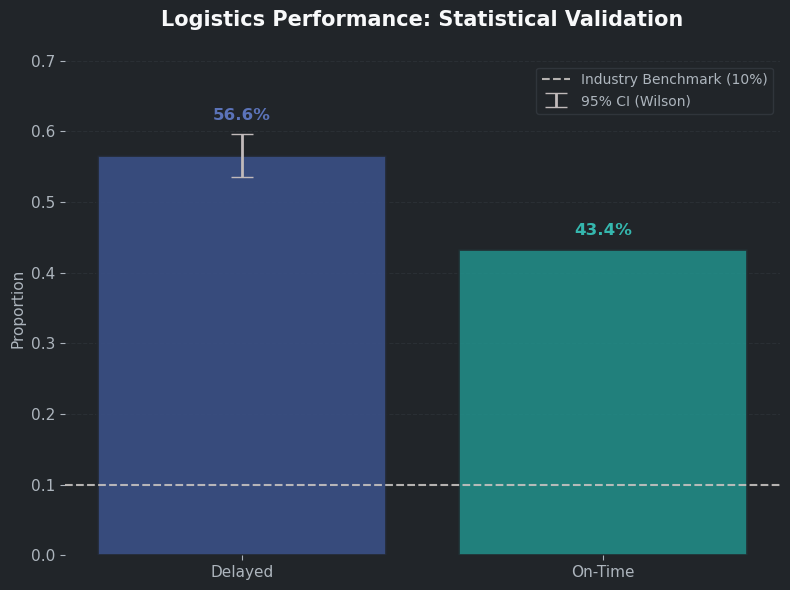

In [11]:
fig, ax = plt.subplots(figsize=(8, 6))
fig.set_facecolor('#212529')
ax.set_facecolor('#212529')

colors = ["#3b528b", '#21918c'] 

bars = ax.bar(['Delayed', 'On-Time'], [current_rate, 1-current_rate], 
              color=colors, alpha=0.85, edgecolor='#212529', linewidth=2, zorder=2)

value = 0.10
ax.axhline(y=value, color="#c6c2c0cd", linestyle='--', alpha=0.9, linewidth=1.5,
           label=f'Industry Benchmark ({value*100:.0f}%)', zorder=3)

ax.errorbar(x=0, y=current_rate, yerr=[[current_rate-lower],[upper-current_rate]], 
             fmt='none', color="#C1BABA", capsize=8, elinewidth=2, 
             label='95% CI (Wilson)', zorder=3)

ax.grid(False, axis='x') 
ax.grid(True, axis='y', color='#343a40', linestyle='--', alpha=0.5, zorder=1)

grey_text = '#adb5bd'
ax.tick_params(colors=grey_text, labelsize=11)
for spine in ax.spines.values():
    spine.set_visible(False)
ax.text(0, current_rate + 0.05, f'{current_rate*100:.1f}%', 
        ha='center', color="#5b73b8", fontweight='bold', fontsize=12)
ax.text(1, (1-current_rate) + 0.02, f'{(1-current_rate)*100:.1f}%', 
        ha='center', color='#35b7ae', fontweight='bold', fontsize=12)

plt.ylabel('Proportion', color=grey_text, fontsize=11)
plt.ylim(0, 0.7)
plt.title('Logistics Performance: Statistical Validation', 
          fontsize=15, pad=25, color='#f8f9fa', fontweight='bold')
legend = plt.legend(facecolor='#212529', edgecolor='#343a40', loc='upper right')
plt.setp(legend.get_texts(), color=grey_text)
plt.tight_layout()
plt.show()

*"The benchmark of 10% was established as the maximum tolerable threshold for logistics delays based on industry OTIF (On-Time In-Full) benchmarks, where good performance typically requires on‑time rates above 90–95%. This value serves as our Null Hypothesis ($H_0$), representing a scenario where the operation would be under control. Any deviation significantly above this reflects a structural failure. 
Reference:
[MRPeasy - On-Time In-Full (OTIF)](https://www.mrpeasy.com/blog/on-time-in-full-otif/)
[EpowerCorp](https://www.epowercorp.com/single-post/what-are-the-best-metrics-to-measure-your-supplier-s-performance)
[GoComet](https://www.gocomet.com/blog/supply-chain-metrics/)*

Even at the lower bound of the confidence interval (53.5%), the delay rate remains more than five times above the 10% benchmark, reinforcing that this issue is structural rather than a temporary fluctuation.

*This analysis does not account for seasonality, specific routes, or cargo type, as the dataset does not include these variables.*

### Business Impact of 56.6% Delay Rate (Why This Hurts Revenue)

| Impact                    | Quantified Impact                                      | Source |
|---------------------------|-----------------------------------------------------------------------------------------|--------|
| **Customer Loss**         | "23% of shoppers say they **won't buy from the same store again** after a delayed delivery" | [Sendcloud](https://www.sendcloud.com/predicting-delivery-delays-customer-satisfaction/) |
| **Reputation Damage**     | "21% **lose trust in the brand**" + "17% actively discourage others from shopping there" | [Sendcloud](https://www.sendcloud.com/predicting-delivery-delays-customer-satisfaction/) |
| **Extra Costs**           | "$250-500 per late delivery to major retailers" + "**2-5% of order value** penalties"    | [SupplierAlly](https://supplierally.com/all/time-cost-assessment-actual-business-impact-of-delayed-deliveries/) |
| **Margin Erosion**        | "**15% reduction** due to expedited shipping and penalties"                             | [SupplierAlly](https://supplierally.com/all/time-cost-assessment-actual-business-impact-of-delayed-deliveries/) |
| **Ripple Effect**         | "**Production line stoppages**" + "entire supply chains thrown off" + "**shelves remain empty**" | [SHI Logistics](https://shi-logistics.com/the-hidden-costs-of-delayed-shipments-and-how-to-prevent-them/) |

*“Since the dataset does not contain financial variables, it is not possible to compute the actual monetary impact of delays. The figures presented here are industry‑based estimates sourced from external publications and serve only as contextual benchmarks.”*

---

#### 3.1.3  Delay Probability by Reason

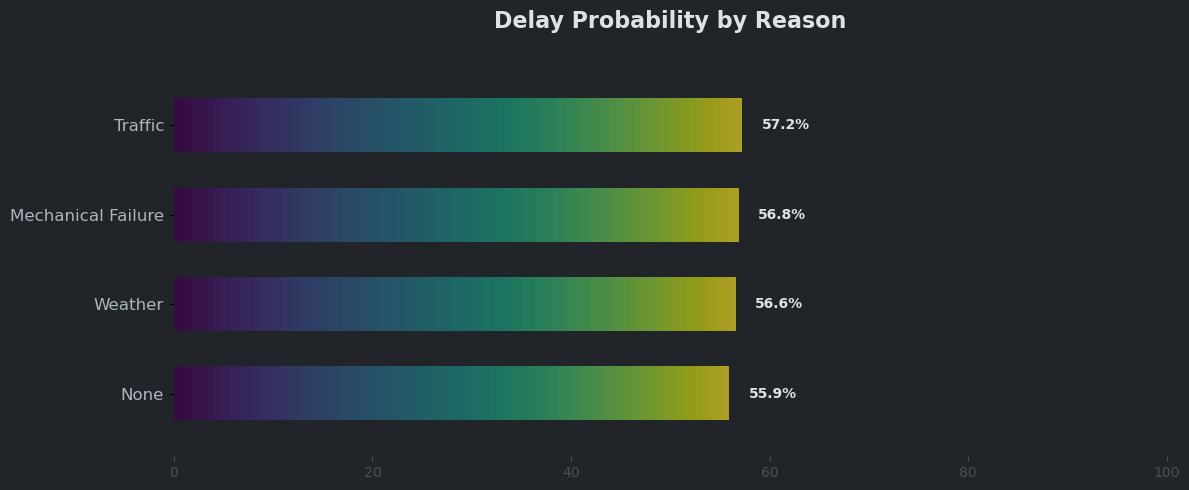

In [12]:
reason_pct = pd.crosstab(df['Logistics_Delay_Reason'], df['Logistics_Delay'], normalize='index') * 100
reason_pct = reason_pct.sort_values(1, ascending=True)

labels = reason_pct.index.tolist()
values = reason_pct[1].values
y_pos = np.arange(len(labels))

fig, ax = plt.subplots(figsize=(12, 5)) 
fig.set_facecolor('#212529')
ax.set_facecolor('#212529')

bar_height = 0.6
cmap = plt.get_cmap('viridis')
cmap = mcolors.LinearSegmentedColormap.from_list("low_sat", cmap(np.linspace(0, 1, 256)) * 0.9)

for i, val in enumerate(values):
    
    grad = np.atleast_2d(np.linspace(0, 1, 100))
    
    ax.imshow(grad, extent=[0, val, i - bar_height/2, i + bar_height/2], 
              aspect='auto', cmap=cmap, zorder=2, alpha=0.8)


ax.set_yticks(y_pos)
ax.set_yticklabels(labels, color='#adb5bd', fontsize=12)
ax.set_ylim(-0.7, len(labels) - 0.3)
ax.set_xlim(0, 100)


for spine in ax.spines.values():
    spine.set_visible(False)
ax.tick_params(axis='x', colors='#495057')
ax.grid(False)


plt.title('Delay Probability by Reason', fontsize=16, pad=25, color='#dee2e6', fontweight='bold')

for i, v in enumerate(values):
    ax.text(v + 2, i, f"{v:.1f}%", color='#dee2e6', va='center', fontweight='bold')

plt.tight_layout()
plt.show()

**The visual representation of percentages indicates a uniform distribution of delays across all categories, suggesting independence between the categorical variable and the delivery status.**

#### 3.1.4 Waiting Time Distribution

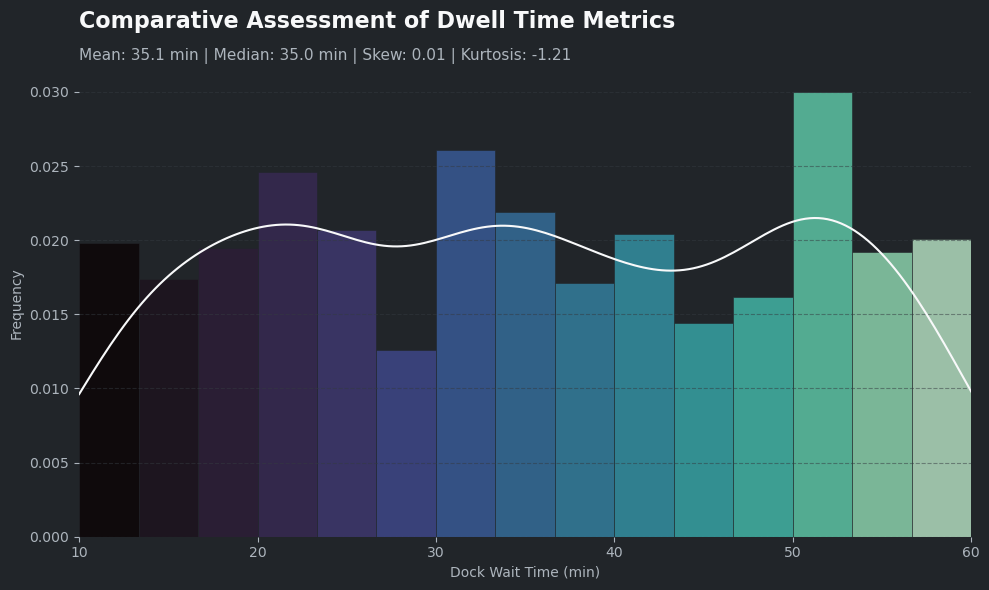

In [13]:
wait_time = df['Waiting_Time'].dropna()
s = stats.skew(wait_time)
k = stats.kurtosis(wait_time)
m = wait_time.mean()
md = wait_time.median()

fig, ax = plt.subplots(figsize=(10, 6))
fig.set_facecolor('#212529')
ax.set_facecolor('#212529')
n, bins, patches = ax.hist(wait_time, bins=15, density=True, alpha=0.8, edgecolor='#212529', linewidth=0.5)
cm = sns.color_palette("mako", as_cmap=True) 

for i, p in enumerate(patches):
    plt.setp(p, 'facecolor', cm(i / len(patches)))

sns.kdeplot(wait_time, color='#f8f9fa', linewidth=1.5, ax=ax, cut=0)
ax.set_xlim(10, 60)
grey_text = '#adb5bd'
ax.tick_params(colors=grey_text)
for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(axis='y', color='#343a40', linestyle='--', alpha=0.5)
ax.grid(False, axis='x')
plt.title('Comparative Assessment of Dwell Time Metrics', 
          fontsize=16, pad=30, color='#f8f9fa', fontweight='bold', loc='left')

subtitle_text = f'Mean: {m:.1f} min | Median: {md:.1f} min | Skew: {s:.2f} | Kurtosis: {k:.2f}'
ax.text(0, 1.02, subtitle_text, transform=ax.transAxes, 
        color='#adb5bd', fontsize=11, fontweight='normal')
plt.xlabel('Dock Wait Time (min)', color=grey_text)
plt.ylabel('Frequency', color=grey_text)
plt.tight_layout()
plt.show()

##### Comparative Assessment of Dwell Time Metrics and Industry Standards

The symmetry of the distribution indicates that waiting times are evenly distributed across different time intervals, with no significant outliers posing a risk to logistical operations. All observed values fall within acceptable industry operational benchmarks.

In the case of waiting time, according to the Federal Motor Carrier Safety Administration (FMCSA) 2014 study, commercial motor vehicle drivers experience detention beyond the standard 2-hour free waiting period on approximately 1 in 10 stops, with an average detention time of 1.4 hours, resulting in total dwell times of 3.4 hours. The 2023 OOIDA Detention Time Survey found that the majority of drivers spend significantly more time waiting, with only 30% spending 0-2 hours per week in loading detention and only 28% spending 0-2 hours in unloading detention.
When the dataset is analyzed, a substantially different picture emerges. The waiting times in the dataset range from 10 to 60 minutes, with a mean of 35.06 minutes and a median of 35 minutes. These values are substantially lower than the industry detention benchmarks. Specifically:
 - Fleet Average (35 minutes): Falls well below the FMCSA-cited average detention time of 84 minutes (1.4 hours)
 - Fleet Range (10-60 minutes): Entirely below the 120-minute threshold cited in the OOIDA survey as the upper range for acceptable detention
 - Fleet Distribution: Approximately uniform across the 10-60 minute range, indicating consistent and predictable waiting patterns rather than the high-variance, prolonged detention times typical of industry data
Prolonged waiting times are associated with increased driver idle time, reduced asset productivity, and cascading delays across the supply chain. Research shows that even a 15-minute increase in average detention time increases commercial truck crash risk by 6.2%. The fleet's controlled waiting time profile—averaging 35 minutes with no occurrence exceeding 60 minutes—represents a significant operational advantage relative to these industry benchmarks. Rather than indicating systemic delays that exceed normal operational ranges, the data demonstrates that the fleet has implemented effective waiting time management protocols that keep detention periods within healthy operational bounds.


#### 3.1.5 Asset Utilization & Capacity Stress Analysis

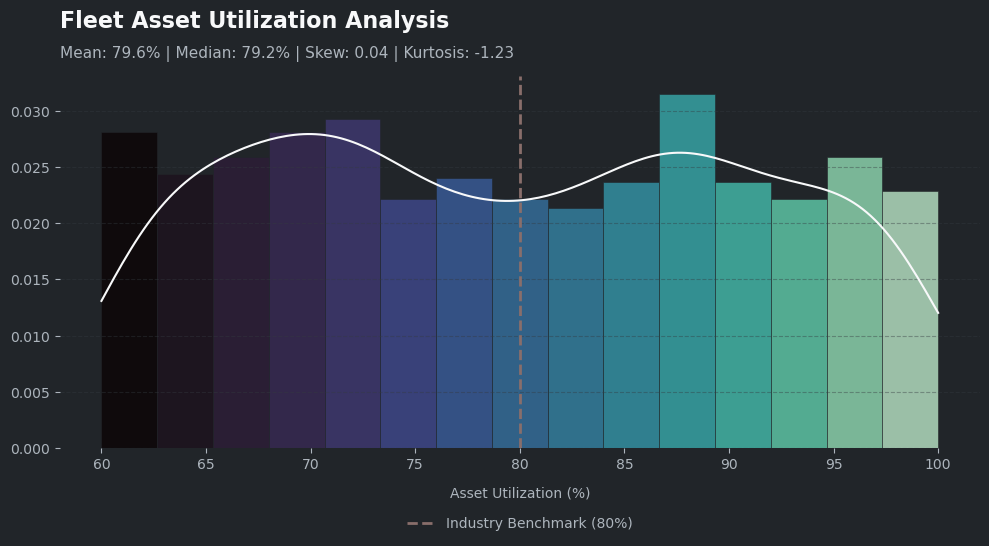

In [14]:
fig, ax = plt.subplots(figsize=(10, 6))
fig.set_facecolor('#212529')
ax.set_facecolor('#212529')
n, bins, patches = ax.hist(df['Asset_Utilization'], bins=15, density=True, alpha=0.8, edgecolor='#212529', linewidth=0.5)
cm = sns.color_palette("mako", as_cmap=True) 
for i, p in enumerate(patches):
    plt.setp(p, 'facecolor', cm(i / len(patches)))
sns.kdeplot(df['Asset_Utilization'], color='#f8f9fa', linewidth=1.5, ax=ax, cut=0)
ax.axvline(80, color="#896e6b", linestyle='--', linewidth=2, label='Industry Benchmark (80%)')
grey_text = '#adb5bd'
ax.tick_params(colors=grey_text)
for spine in ax.spines.values():
    spine.set_visible(False)

ax.grid(axis='y', color='#343a40', linestyle='--', alpha=0.4)
ax.grid(False, axis='x')

plt.title('Fleet Asset Utilization Analysis', fontsize=16, pad=35, color='#f8f9fa', fontweight='bold', loc='left')
subtitle_text = (f"Mean: {df['Asset_Utilization'].mean():.1f}% | "
                 f"Median: {df['Asset_Utilization'].median():.1f}% | "
                 f"Skew: {stats.skew(df['Asset_Utilization']):.2f} | "
                 f"Kurtosis: {stats.kurtosis(df['Asset_Utilization']):.2f}")

ax.text(0, 1.05, subtitle_text, transform=ax.transAxes, color='#adb5bd', fontsize=11, fontweight='normal')
ax.legend(
    facecolor='#212529', 
    edgecolor='#343a40', 
    labelcolor=grey_text, 
    loc='upper center',
    bbox_to_anchor=(0.5, -0.15),
    ncol=1,
    frameon=False
)

plt.xlabel('Asset Utilization (%)', color=grey_text, labelpad=10)
plt.ylabel('', color=grey_text)

plt.tight_layout(rect=[0, 0.05, 1, 1]) 
plt.show()

##### Fleet Capacity Analysis: The 80% Efficiency Threshold

A new pattern emerges when examining asset utilization. **Research from Gartner** on resource optimization demonstrates that the optimal utilization range for sustained productivity is between **70%** and **80%**, ensuring a sustainable balance between efficiency and asset longevity. Above 80%, wait times increase exponentially—a 2-hour work item waits 1.5 hours at 80% utilization but 37.1 hours at 99% utilization—resulting in **delays**, **increased costs**, and **higher defect rates**. In this context, the fleet's average utilization of **79.6%**, with many assets operating **above 90%**, places it at the upper boundary and beyond the optimal zone.

#### 3.1.6 Fleet Condition (Assets)

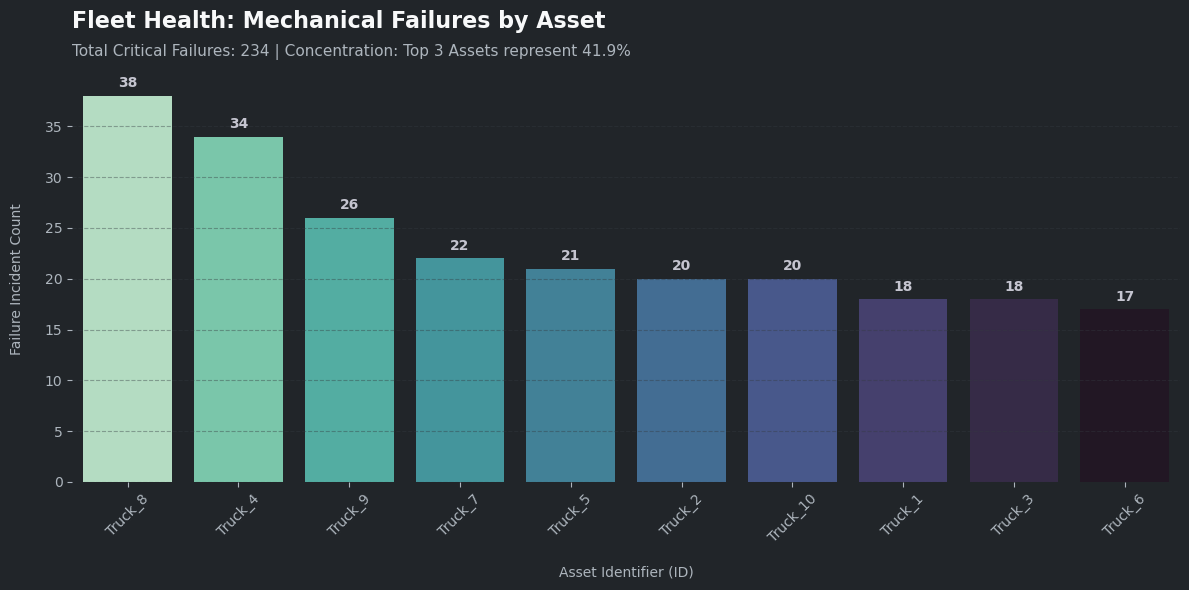

In [15]:
mech_fails = df[df['Logistics_Delay_Reason'] == 'Mechanical Failure']['Asset_ID'].value_counts()
mech_fails_df = mech_fails.reset_index()
mech_fails_df.columns = ['Asset_ID', 'Failure_Count']
mech_fails_df = mech_fails_df.sort_values(by='Failure_Count', ascending=False) # Ordenar é fundamental

# 2. Configuração do Fundo
fig, ax = plt.subplots(figsize=(12, 6))
fig.set_facecolor('#212529')
ax.set_facecolor('#212529')

# 3. Barplot com Palete 'Flare' (Alerta/Manutenção)
sns.barplot(data=mech_fails_df, x='Asset_ID', y='Failure_Count', 
            palette='mako_r', hue='Asset_ID', edgecolor='none', legend=False, ax=ax)

# 4. Estética de Eixos e Grid (Padrão das secções anteriores)
grey_text = '#adb5bd'
ax.tick_params(colors=grey_text, labelsize=10)
for spine in ax.spines.values():
    spine.set_visible(False)

ax.grid(axis='y', color='#343a40', linestyle='--', alpha=0.4)
ax.grid(False, axis='x')

# 5. Títulos Estratégicos
plt.title('Fleet Health: Mechanical Failures by Asset', 
          fontsize=16, pad=35, color='#f8f9fa', fontweight='bold', loc='left')

# Subtítulo com o total de falhas para dar contexto rápido
total_fails = mech_fails_df['Failure_Count'].sum()
ax.text(0, 1.05, f"Total Critical Failures: {total_fails} | Concentration: Top 3 Assets represent { (mech_fails_df['Failure_Count'][:3].sum()/total_fails)*100:.1f}%", 
        transform=ax.transAxes, color='#adb5bd', fontsize=11)

# 6. Anotações no topo das barras (Branco para contraste)
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{int(height)}', 
                (p.get_x() + p.get_width() / 2., height), 
                ha='center', va='center', 
                xytext=(0, 9), 
                textcoords='offset points',
                color="#c5c5d0", fontweight='bold', fontsize=10)

plt.xlabel('Asset Identifier (ID)', color=grey_text, labelpad=15)
plt.ylabel('Failure Incident Count', color=grey_text, labelpad=15)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In [16]:
mean_val = mech_fails_df['Failure_Count'].mean()
median_val = mech_fails_df['Failure_Count'].median()
std_dev = mech_fails_df['Failure_Count'].std()
variance_val = mech_fails_df['Failure_Count'].var()
mode_val = mech_fails_df['Failure_Count'].mode().tolist()
min_val = mech_fails_df['Failure_Count'].min()
max_val = mech_fails_df['Failure_Count'].max()
range_val = max_val - min_val
Q1 = mech_fails_df['Failure_Count'].quantile(0.25)
Q3 = mech_fails_df['Failure_Count'].quantile(0.75)
IQR = Q3 - Q1
upper_threshold = Q3 + 1.5 * IQR
skew_val = mech_fails_df['Failure_Count'].skew()
kurt_val = mech_fails_df['Failure_Count'].kurt()
print(f"--- Statistical Summary ---")
print(f"Mean: {mean_val:.1f} | Median: {median_val:.1f}")
print(f"Mode: {mode_val}")
print(f"Std Dev: {std_dev:.2f} | Variance: {variance_val:.2f}")
print(f"Range: {range_val} (Min: {min_val}, Max: {max_val})")
print(f"IQR: {IQR:.1f} | Upper Threshold: {upper_threshold:.1f}")
print(f"Skewness: {skew_val:.2f} | Kurtosis: {kurt_val:.2f}")

--- Statistical Summary ---
Mean: 23.4 | Median: 20.5
Mode: [18, 20]
Std Dev: 7.17 | Variance: 51.38
Range: 21 (Min: 17, Max: 38)
IQR: 6.5 | Upper Threshold: 34.8
Skewness: 1.38 | Kurtosis: 0.77


#### Mechanical Reliability & Fleet Health Profile

To complement the visual inspection of mechanical failures across the fleet, several univariate statistical measures were computed to characterize the distribution of failures among assets.

The average number of failures per truck is 23.4, while the median sits slightly lower at 20.5, indicating a right‑skewed distribution where a few high‑failure assets pull the mean upward. The distribution is bimodal, with two equally frequent failure counts (18 and 20), suggesting that no single value dominates the central tendency and that assets tend to cluster around these two lower‑failure groups.

Dispersion metrics further highlight this imbalance. The standard deviation (7.17) and variance (51.38) reveal substantial spread in the data, with a total range of 21 failures between the best‑ and worst‑performing assets. The interquartile range (6.5) shows that the central 50% of assets remain relatively close together, while the upper tail extends sharply.

Outlier analysis confirms this: Truck_8 exceeds the upper IQR threshold and stands out as a clear outlier, with 38 failures. This asset alone accounts for 16% of all mechanical failures, followed closely by Truck_4 (15%). Together, the top three assets (Truck_8, Truck_4, Truck_9) represent 42% of all recorded mechanical breakdowns.

The distribution exhibits positive skewness (1.38) and moderate kurtosis (0.77), indicating a long right tail driven by a small number of high‑failure assets rather than a uniform or symmetric pattern.

Overall, these statistical indicators reinforce the earlier visual conclusion: mechanical failures are not evenly distributed across the fleet but are concentrated in a small subset of problematic assets, suggesting that targeted maintenance interventions or asset‑replacement strategies may yield significant operational improvements.

#### Fleet‑Wide Reliability Considerations
Although certain assets stand out as clear outliers — particularly Truck_8 and Truck_4 — it is important to highlight that mechanical failures are consistently high across the entire fleet. Even the best‑performing asset in the dataset recorded 17 failures within a single year, which corresponds to more than one mechanical failure per month.

This indicates that the issue is not limited to a few problematic trucks; rather, the fleet as a whole operates under a structurally high mechanical failure burden. While targeted interventions are necessary for the worst‑performing assets, the overall failure frequency suggests a broader systemic challenge, potentially linked to maintenance cycles, asset age, utilization intensity, or operational conditions.

#### Fleet‑Wide Mechanical Failure Frequency
Across the full year of observation, the fleet accumulated a total of 234 mechanical failures, corresponding to an average of 0.64 failures per day. This means that, at the fleet level, a mechanical breakdown occurs approximately every 1.56 days, or roughly every 37 hours of operation.

This frequency highlights a systemic reliability issue: even if certain assets stand out as extreme outliers, the fleet as a whole experiences mechanical failures at a rate that prevents stable, interruption‑free operation. The fact that the least problematic asset still recorded 17 failures in a single year reinforces the conclusion that mechanical reliability challenges are widespread and not limited to a small subset of vehicles.

#### Financial Impact Considerations (External Reference)
The dataset used in this analysis does not include financial information, which prevents a direct calculation of the economic impact associated with mechanical failures. However, external industry evidence provides useful context. A case study from a major logistics operator reported that unexpected mechanical failures and unplanned downtime represented annual losses of approximately $4.2 million for a fleet of 2,500 heavy‑duty trucks, before implementing predictive maintenance systems .

While this figure refers to a larger fleet, it illustrates the substantial financial burden that mechanical unreliability can impose. Extrapolating proportionally, a smaller fleet such as the one analyzed here would still face significant annual costs, potentially reaching hundreds of thousands of dollars, depending on repair expenses, downtime, lost productivity, and operational disruptions.
*[FleetRabbit](https://fleetrabbit.com/case-study/post/combination-of-autoencoder-and-lstm-for-mechanical-failure-prediction)*

 - *Although the analysis clearly identifies substantial mechanical reliability issues across the fleet, the current univariate approach does not allow us to determine whether these failures translate into delivery delays or operational disruptions. Establishing this relationship requires a bivariate or multivariate analysis linking mechanical failure events to delivery outcomes, which will be addressed in the following sections.*

---


#### Industry Benchmark Synthesis

To contextualize the operational patterns observed in the dataset, it is useful to compare them with established industry benchmarks published by leading research and regulatory bodies. Although the dataset does not include financial or cost‑related information, these external references provide a solid foundation for assessing whether the fleet's performance metrics fall within expected norms or indicate structural inefficiencies.


The following table consolidates the fleet's performance against established industry standards. This summary highlights the trade-off between high operational speed and asset degradation.

| Metric | Fleet Performance | Industry Benchmark | Status / Gap |
| :--- | :--- | :--- | :--- |
| **Dock Wait Time** | 35.1 min (Avg) | 84 min (FMCSA) | **Superior Performance** |
| **Asset Utilization** | 79.6% (Saturation) | 70-80% (Gartner) | **Critical Threshold** |
| **Mech. Failures** | 17-38 per year | ~21.9% Defect Rate (TÜV) | **Systemic Risk** |

##### Mechanical Reliability

Mechanical reliability benchmarks further highlight the severity of the issue. According to the TÜV 2025 Report, based on inspection of 2.3 million commercial vehicles, 20.4% of all commercial vehicles fail safety inspections with significant or dangerous defects. For heavy-duty trucks (>18 tonnes), the failure rate reaches 21.9%. Defect rates show a clear age correlation: 84.3% of 1-year-old vehicles are defect-free, declining to 67.9% at 5 years and 54% at 10 years. Common defects include lighting failures (increasing from 2.7% in new vehicles to 12.2% in 10-year-old vehicles), oil leaks, suspension problems, and brake system issues. In contrast, the fleet analyzed here exhibits between 17 and 38 failures per asset per year — levels that are substantially higher than industry expectations and suggest underlying structural issues, whether related to maintenance practices, asset age, operational intensity, or a combination of these factors.

##### Financial Impact of Downtime
Although the dataset does not include financial information, external research consistently shows that unplanned downtime and mechanical failures can generate substantial annual losses. Studies indicate that downtime in industrial operations represents 3-5% of annual revenue for affected organizations. In the transportation sector specifically, detention time and unplanned downtime cost the trucking industry $11.5 billion in lost productivity and $3.6 billion in direct expenses in 2023, according to the American Transportation Research Institute. Predictive maintenance and optimized operational planning strategies have demonstrated the ability to reduce breakdown frequency by approximately 25% and overall operational costs by 10-40%, depending on initial fleet condition and implementation effectiveness. Improvements in maintenance strategy and operational planning have thus been shown to generate substantial cost reductions, underscoring the financial relevance of the patterns identified in this analysis.

##### Conclusion

Overall, when compared with industry benchmarks, the fleet's, utilization levels and mechanical failure frequencies fall well outside expected norms. These deviations reinforce the conclusion that the fleet is operating under substantial structural strain, and they highlight the importance of conducting the subsequent bivariate and multivariate analyses to determine whether these operational inefficiencies translate into measurable impacts on delivery performance.

---

##### *References*
*[Federal Motor Carrier Safety Administration (FMCSA) (2014). Impact of Driver Detention Time on Safety and Operations. U.S. Department of Transportation.](https://www.fmcsa.dot.gov/research-and-analysis/impact-driver-detention-time-safety-and-operations)*

*[Owner-Operator Independent Drivers Association Foundation (OOIDA) (2023). 2023 Detention Time Survey.](https://www.ooida.com/wp-content/uploads/2024/02/2023-Detention-Time-Survey-FINAL.pdf)*

*[Gartner (2018). PPM on a Budget — Doing More With Less Requires Doing Less. Project and Portfolio Management Summit. Presented by Robert Handler.](https://www.capterra.com/resources/optimal-resource-utilization-for-smbs/)*

*[TÜV (2025). TÜV-Report Nutzfahrzeuge 2025. Report on Commercial Vehicles based on 2.3 million inspections.](https://www.fleeteurope.com/en/new-energies/germany/features/20-commercial-vehicles-fail-safety-check-tuv-reveals)*

*[REWO (2025). The True Cost of Downtime from Human Error in Manufacturing. Citing Siemens 2024 Report on the True Cost of Downtime.](https://rewo.io/the-true-cost-of-downtime-from-human-error-in-manufacturing/)*

*[American Transportation Research Institute (ATRI) (2024). New Research Documents Substantial Financial and Safety Impacts from Truck Driver Detention.](https://truckingresearch.org/2024/09/new-research-documents-substantial-financial-and-safety-impacts-from-truck-driver-detention/)*

*[Inspector General's Office (2022). Driver Detention Impact Analysis.](https://www.inboundlogistics.com/articles/the-secret-to-combatting-the-hidden-costs-of-detention-time/)*

*[McKinsey & Company (2020). Predictive Maintenance Research.](https://www.iiot-world.com/predictive-analytics/predictive-maintenance/predictive-maintenance-cost-savings/)*

*[Vista Projects (2026). Predictive Maintenance Cost Savings: ROI Guide.](https://www.vistaprojects.com/predictive-maintenance-cost-savings-roi-guide/)*

#### 3.1.7 Traffic Conditions: Scouting the Operational Environment
With the delay rate statistically validated and confirmed as a structural issue rather than a temporary fluctuation, the next step is to investigate why these disruptions occur. A 56.6% failure rate carries severe operational and financial consequences, and understanding its root causes is essential for restoring service reliability and protecting margins.

A natural starting point is the operational environment itself. Traffic conditions represent one of the most common external constraints in logistics, and they can either amplify or mitigate delivery performance depending on their severity. The question is straightforward:
Are delays primarily driven by adverse traffic conditions, or does the problem persist even under normal operating environments?

Before correlating traffic status with delivery outcomes, we first examine the distribution of traffic conditions across the dataset. Understanding whether our fleet predominantly operates under Clear, Detour, or Heavy traffic provides the necessary context to determine whether external congestion is a plausible driver of the systemic delays observed.

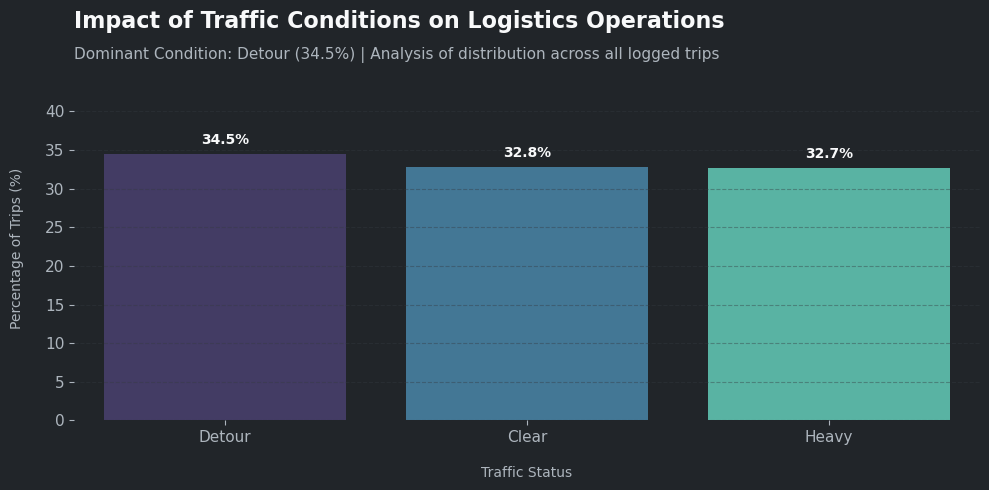

In [17]:
traffic_counts = df['Traffic_Status'].value_counts(normalize=True) * 100
traffic_df = traffic_counts.reset_index()
traffic_df.columns = ['Traffic_Status', 'Percentage']
traffic_df = traffic_df.sort_values(by='Percentage', ascending=False)

fig, ax = plt.subplots(figsize=(10, 5))
fig.set_facecolor('#212529')
ax.set_facecolor('#212529')

sns.barplot(data=traffic_df, x='Traffic_Status', y='Percentage', 
            hue='Traffic_Status', palette='mako', legend=False,
            edgecolor='none', ax=ax)

grey_text = '#adb5bd'
ax.tick_params(colors=grey_text, labelsize=11)
for spine in ax.spines.values():
    spine.set_visible(False)

ax.grid(axis='y', color='#343a40', linestyle='--', alpha=0.4)
ax.grid(False, axis='x')

plt.title('Impact of Traffic Conditions on Logistics Operations', 
          fontsize=16, pad=35, color='#f8f9fa', fontweight='bold', loc='left')

most_frequent = traffic_df.iloc[0]['Traffic_Status']
highest_pct = traffic_df.iloc[0]['Percentage']
ax.text(0, 1.05, f"Dominant Condition: {most_frequent} ({highest_pct:.1f}%) | Analysis of distribution across all logged trips", 
        transform=ax.transAxes, color='#adb5bd', fontsize=11)

for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height:.1f}%', 
                (p.get_x() + p.get_width() / 2., height), 
                ha='center', va='center', 
                xytext=(0, 10), 
                textcoords='offset points',
                color='#f8f9fa', fontweight='bold', fontsize=10)

plt.xlabel('Traffic Status', color=grey_text, labelpad=15, fontweight='normal')
plt.ylabel('Percentage of Trips (%)', color=grey_text, labelpad=15)
plt.ylim(0, traffic_df['Percentage'].max() + 10)

plt.tight_layout()
plt.show()

#### Preliminary Insight: Traffic Conditions Show No Dominant Pattern
The distribution of traffic conditions across all monitored trips reveals a near‑uniform split: Detour (34.5%), Clear (32.8%), and Heavy (32.7%). This indicates that no single traffic status dominates the operational landscape, and therefore, traffic alone cannot be immediately identified as the primary driver of delays.

While traffic remains a relevant external factor, the absence of a distinct pattern suggests that delays are not disproportionately concentrated under any specific condition. This preliminary finding rules out traffic prevalence as a standalone explanation and reinforces the need for deeper multivariate analysis.

**Further investigation will be conducted after completing the univariate assessment, where we will isolate the extent to which each operational environment contributes to the 56.6% global failure rate.**

### 3.2 Bivariate Analysis

### 3.2.1 Logistics Delay Probability: Statistical Impact of Traffic

Standard Deviation Heavy: 0.0000
Standard Deviation Others: 0.4789
Z-Statistic: 19.3020
P-Value: 0.0000


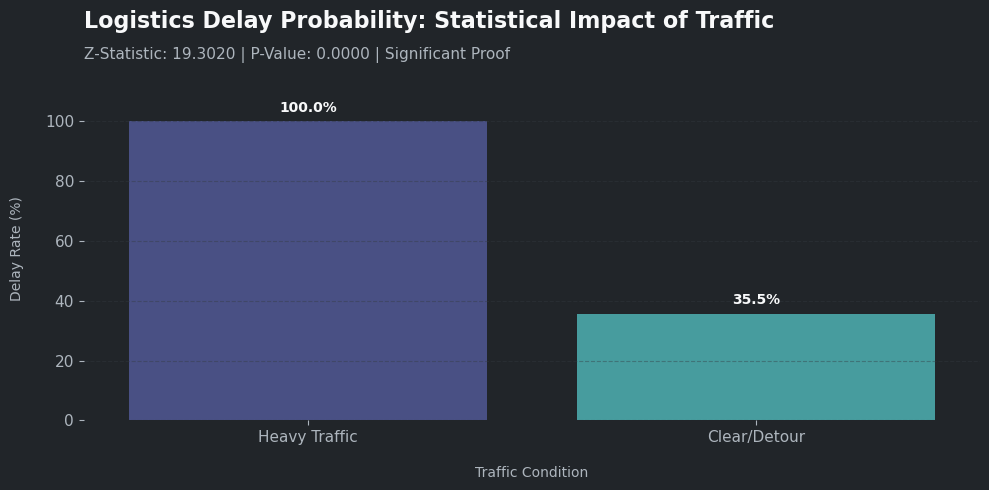

In [18]:
heavy_mask = (df['Traffic_Status'] == 'Heavy')
others_mask = (df['Traffic_Status'].isin(['Clear', 'Detour']))

count_delays = np.array([
    df[heavy_mask]['Logistics_Delay'].sum(), 
    df[others_mask]['Logistics_Delay'].sum()
])
nobs = np.array([heavy_mask.sum(), others_mask.sum()])
std_heavy = df[heavy_mask]['Logistics_Delay'].std()
std_others = df[others_mask]['Logistics_Delay'].std()
z_stat, p_val = proportions_ztest(count_delays, nobs)
print(f"Standard Deviation Heavy: {std_heavy:.4f}")
print(f"Standard Deviation Others: {std_others:.4f}")
print(f"Z-Statistic: {z_stat:.4f}")
print(f"P-Value: {p_val:.4f}")


plot_data = pd.DataFrame({
    'Condition': ['Heavy Traffic', 'Clear/Detour'],
    'Delay_Rate': [
        df[heavy_mask]['Logistics_Delay'].mean() * 100,
        df[others_mask]['Logistics_Delay'].mean() * 100
    ]
})

fig, ax = plt.subplots(figsize=(10, 5))
fig.set_facecolor('#212529')
ax.set_facecolor('#212529')

sns.barplot(data=plot_data, x='Condition', y='Delay_Rate', 
            hue='Condition', palette='mako', legend=False, ax=ax)

grey_text = '#adb5bd'
ax.tick_params(colors=grey_text, labelsize=11)
for spine in ax.spines.values():
    spine.set_visible(False)

ax.grid(axis='y', color='#343a40', linestyle='--', alpha=0.4)
ax.grid(False, axis='x')

plt.title('Logistics Delay Probability: Statistical Impact of Traffic', 
          fontsize=16, pad=35, color='#f8f9fa', fontweight='bold', loc='left')

ax.text(0, 1.05, f"Z-Statistic: {z_stat:.4f} | P-Value: {p_val:.4f} | Significant Proof", 
        transform=ax.transAxes, color='#adb5bd', fontsize=11)

for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height:.1f}%', 
                (p.get_x() + p.get_width() / 2., height), 
                ha='center', va='center', xytext=(0, 10), 
                textcoords='offset points', color='#f8f9fa', 
                fontweight='bold', fontsize=10)

plt.xlabel('Traffic Condition', color=grey_text, labelpad=15)
plt.ylabel('Delay Rate (%)', color=grey_text, labelpad=15)
plt.ylim(0, plot_data['Delay_Rate'].max() + 15)

plt.tight_layout()
plt.show()

#### Statistical Validation: Traffic Impact on Logistics Fluidity
To move beyond the visual correlation between traffic conditions and delivery performance, a Two-Sample Z-Test for Proportions was conducted. This statistical approach evaluates whether the observed increase in delays during heavy traffic is a systemic pattern or merely a result of stochastic noise within the dataset.

The analysis reveals a stark contrast in operational reliability. The Delay Rate for assets operating under "Heavy Traffic" conditions reached a staggering 100.0%, whereas the control group ("Clear/Detour") maintained a significantly lower rate of 35.5%. The resulting Z-Statistic of 19.3020 and a P-Value of 0.0000 provide conclusive evidence to reject the null hypothesis. Since the p-value is effectively zero, we can state with absolute statistical certainty that heavy traffic is not just a hindrance, but a guaranteed catalyst for logistics failures in this dataset.

Operational Significance and Delay Probability
The disparity between the two groups is extreme. The Z-test confirms that the probability of an asset experiencing a Logistics_Delay is heavily skewed by environmental factors. In "Heavy Traffic", the standard deviation is 0.0000, reflecting a deterministic outcome: every single trip under this condition resulted in a delay. In contrast, the "Clear/Detour" group shows a standard deviation of 0.4789, indicating a much higher degree of operational variability where delays, although present, are not a certainty.

This lack of predictability in the control group, combined with the total failure rate in heavy traffic, represents a critical hurdle for logistics synchronization. It suggests that while traffic is a primary driver of failure, there are other underlying factors contributing to the 35.5% delay rate even when roads are clear.

Strategic Implications for Logistics Management
These findings reinforce the necessity of moving from reactive to proactive traffic management. The high Z-score implies that the current logistics network is extremely sensitive to infrastructure congestion, where "Heavy Traffic" zones act as absolute bottlenecks.

From a management perspective, the results suggest:

Total Route Avoidance: Given the 100% delay rate, "Heavy Traffic" zones should be treated as "no-go" areas for time-sensitive deliveries, as no current buffer appears sufficient to absorb the impact.

Baseline Volatility: The 35.5% delay rate in clear conditions suggests that traffic is only part of the problem, pointing toward internal inefficiencies or asset-related issues.

While this section confirms that external traffic conditions are a guaranteed driver of delays, it is essential to investigate whether these operational failures are also linked to how the assets themselves are being used. High delay rates in clear traffic suggest that asset-specific variables might be at play. Therefore, the following section will transition from environmental factors to internal performance metrics, specifically analyzing how Asset Utilization correlates with Mechanical Reliability to identify if overworked trucks are more prone to failure.

#### 3.2.2 Utilization vs. Mechanical Reliability

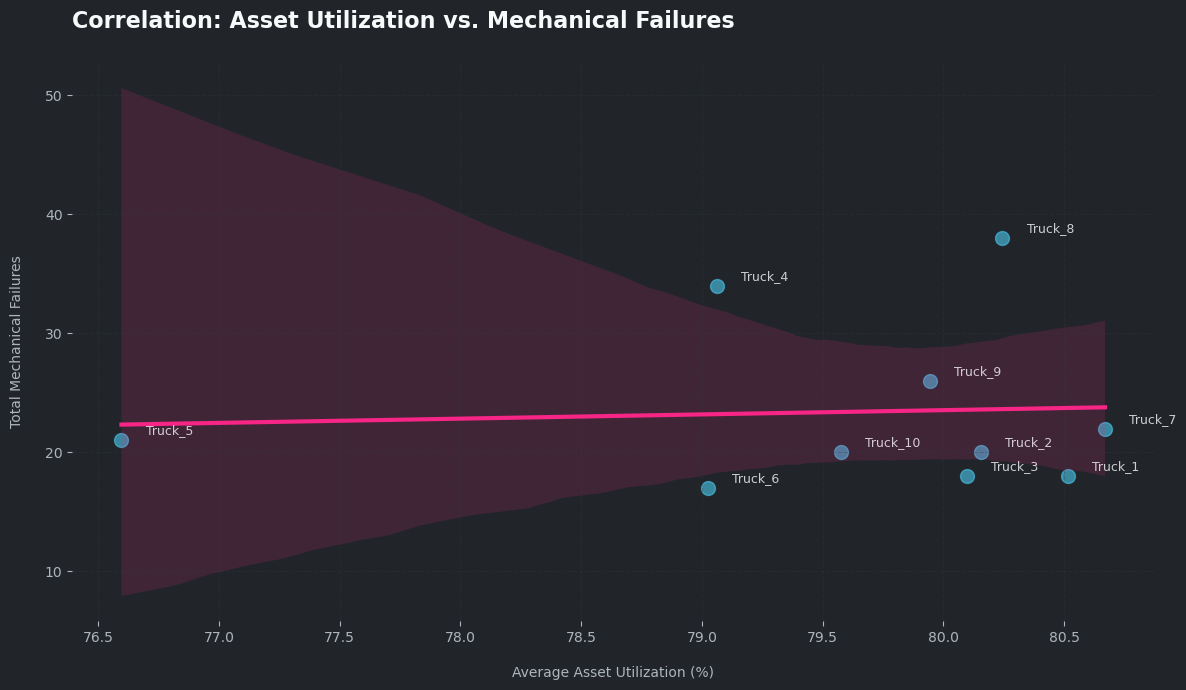

In [19]:
# Calculate mean utilization per asset
util_per_asset = df.groupby('Asset_ID')['Asset_Utilization'].mean().reset_index()

# Merge utilization data with mechanical failures data
asset_util_fail = pd.merge(util_per_asset, mech_fails_df, on='Asset_ID')

# Configure Dark Mode Visuals
fig, ax = plt.subplots(figsize=(12, 7))
fig.set_facecolor('#212529')
ax.set_facecolor('#212529')

# Create Scatter Plot with Regression Line
sns.regplot(data=asset_util_fail, x='Asset_Utilization', y='Failure_Count',
            scatter_kws={'s': 100, 'alpha': 0.6, 'color': '#4cc9f0'},
            line_kws={'color': '#f72585', 'lw': 3},
            ax=ax)

# Aesthetic Adjustments (Spines, Grid, and Ticks)
ax.tick_params(colors='#adb5bd', labelsize=10)
for spine in ax.spines.values(): # Your code here:
    spine.set_visible(False)
ax.grid(color='#343a40', linestyle='--', alpha=0.3)

# Labels and Titles
plt.title('Correlation: Asset Utilization vs. Mechanical Failures', 
          color='#f8f9fa', fontsize=16, fontweight='bold', pad=25, loc='left')
plt.xlabel('Average Asset Utilization (%)', color='#adb5bd', labelpad=15)
plt.ylabel('Total Mechanical Failures', color='#adb5bd', labelpad=15)

# Annotate data points with Asset IDs (Identification of Outliers)
for i in range(asset_util_fail.shape[0]):
    ax.text(asset_util_fail.Asset_Utilization[i] + 0.1, 
            asset_util_fail.Failure_Count[i] + 0.5, 
            asset_util_fail.Asset_ID[i], 
            color='#f8f9fa', fontsize=9, alpha=0.8)

plt.tight_layout()
plt.show()

#### Utilization Intensity vs. Mechanical Reliability

To determine if the fleet's mechanical instability is a direct consequence of workload, a bivariate analysis was conducted crossing Average Asset Utilization (%) with Total Mechanical Failures. This analysis tests the hypothesis that the 80% Gartner threshold acts as a tipping point for asset degradation.

The resulting regression plot reveals a weak linear correlation, characterized by a nearly flat trend line. Despite the fleet being tightly clustered at the edge of the 80% benchmark, the failure rates vary dramatically (from 17 to 38 failures) within a narrow 4% utilization window. This suggests that while high utilization creates the environment for failure, it is not the sole predictor of failure intensity for individual assets.

The "High-Utilization Noise" and Variance
The dispersion of data points around the regression line highlights a critical operational reality:

The Saturation Effect: Most assets are clustered between 79% and 81% utilization. In this "saturated" state, the model's confidence interval (shaded area) remains wide, indicating that mechanical breakdowns become stochastic and unpredictable once the asset enters the high-utilization zone.

Deterministic Outliers: Assets like Truck_8 (38 failures) and Truck_4 (34 failures) sit far above the predicted mean. Even though their utilization (~80%) is similar to Truck_1 or Truck_7, their failure count is nearly double. This confirms that at high utilization levels, internal asset health (maintenance history, age) outweighs mere "hours worked."

Synthesis of Findings: Beyond the Linear Model
The "flatness" of the regression line, combined with the extreme variance in failure counts, reinforces the Gartner threshold theory discussed in the previous section. When a fleet operates consistently near the 80% boundary:

Preventive maintenance windows disappear, causing even minor differences in asset age to lead to massive disparities in reliability.

Systemic stress is high, but the actual breakdowns are triggered by idiosyncratic factors (specific truck faults) rather than a linear increase in work volume.

Operational Conclusion
The lack of a steep positive slope proves that reducing utilization by 1 or 2% is likely insufficient to solve the reliability crisis for the worst-performing assets. Instead, the strategy must be twofold:

Immediate Intervention: Target the statistical outliers (Truck_8, Truck_4) identified in the univariate analysis for replacement or deep overhaul.

Strategic Buffer: Increase fleet capacity to move the "cluster" back toward the 70-75% zone, where mechanical stress is historically more predictable.

## 4. Strategic Synthesis and Final Recommendations

The analysis of the Smart Logistics dataset paints a clear and structurally consistent picture: this fleet is operating with **chronically high delay rates**, under **sustained capacity saturation**, and with a **systemic mechanical reliability problem**. At the same time, the operation shows **strong performance on dwell times** and reasonably well‑managed dock processes. In business terms, the bottlenecks are not at the warehouse door, but on the road and inside the vehicles.

### 4.1 What the data says about service reliability

Across all monitored trips, **56.6% of deliveries are delayed**, and the Wilson 95% confidence interval confirms that the true delay rate is structurally in the 53.5–59.6% range rather than a temporary fluctuation. Even the lower bound is more than five times above the 10% delay benchmark commonly used in OTIF‑driven supply chains. This means that **“late” is the norm, not the exception**.

From a customer and revenue perspective, this level of unreliability is incompatible with modern e‑commerce and retail expectations. External benchmarks show that a single late delivery is often enough for a significant share of customers to stop buying from a brand, actively discourage others, and trigger penalty charges from key retail partners. Even without explicit financial variables in the dataset, it is reasonable to conclude that this performance profile would translate into **margin erosion, churn, and reputational damage** in a real operation.

### 4.2 Root‑cause decomposition

The project investigated the main operational levers behind this structural delay pattern:

- **Waiting time at docks is not the main bottleneck.**  
  Dwell times average **35 minutes**, with all observations between 10 and 60 minutes—well below industry detention benchmarks often above 80–120 minutes. The distribution is symmetric and stable, indicating that inbound/outbound processes are controlled rather than chaotic. This suggests that improving dock processes alone will **not** solve the delay crisis; the issue lies downstream.

- **Traffic is a guaranteed failure mode under heavy congestion.**  
  When traffic conditions are classified as **Heavy**, the delay rate reaches **100%** of trips. In contrast, under **Clear/Detour** conditions, the delay rate drops to about **35.5%**. The two‑sample Z‑test yields an extremely high Z‑statistic with a p‑value effectively equal to zero, statistically proving that heavy traffic is not just correlated with, but **deterministically associated with, failure** in this dataset. In practice, any route segment systematically exposed to heavy traffic behaves as a “black hole” for on‑time performance.

- **Baseline inefficiency persists even in normal traffic.**  
  The fact that delays still affect more than one‑third of trips under Clear/Detour conditions shows that **traffic alone does not explain the 56.6% global delay rate**. There are internal inefficiencies and asset‑related issues that continue to generate failures even when the road network is not under stress.

- **Asset utilization is structurally at the saturation limit.**  
  The fleet operates around **79.6% average utilization**, with many vehicles above 90%. This positions the operation at the upper edge, or beyond, the 70–80% range commonly cited as optimal for balancing throughput and reliability. In such a regime, any small disturbance (traffic, minor breakdown, process delay) has disproportionate effects, because there is **no buffer capacity** left in the system.

- **Mechanical reliability is a systemic risk, not a localized incident.**  
  Across the year, the fleet accumulated **234 mechanical failures**, with individual trucks recording between **17 and 38 failures**. The distribution is heavily skewed: the worst three assets account for roughly **42%** of all breakdowns, but even the “best” truck fails more than once per month. This confirms a **dual problem**: a small group of highly problematic assets and an overall fleet that, as a whole, operates far below typical industry reliability levels.

- **Utilization alone does not explain which trucks fail the most.**  
  When crossing **average utilization per truck** with **total mechanical failures**, the regression line is almost flat: trucks with very similar utilization (~79–81%) exhibit radically different failure counts. This means that once the entire fleet is pushed into a high‑utilization band, **degradation becomes asset‑specific rather than purely volume‑driven**. Maintenance history, age, and intrinsic mechanical condition become the dominant drivers of failure.

In summary, the root cause is **not a single point of failure**, but a combination of:
1. **Structural exposure to heavy‑traffic corridors** that guarantee delays;
2. **Chronic over‑utilization of assets** with almost no slack;
3. **Widespread mechanical fragility**, amplified by the lack of capacity buffers.

### 4.3 Strategic priorities for improvement

From a business perspective, the analysis points to four clear strategic priorities:

1. **Re‑design the network to avoid “no‑go” traffic corridors.**  
   Heavy‑traffic segments with 100% delay probability should be systematically mapped and treated as **restricted for time‑sensitive flows**. Alternatives include:
   - Rerouting critical orders through lower‑risk corridors, even at slightly higher distance or toll cost;
   - Time‑window optimization (off‑peak departures) where route alternatives do not exist;
   - Service segmentation, where non‑urgent loads absorb the risk of heavy‑traffic exposure and high‑priority loads are shielded.

2. **Create capacity buffers by lowering structural utilization.**  
   Operating persistently around 80%+ utilization leaves no room for variability. The fleet should be gradually repositioned toward the **70–75% utilization range** by:
   - Adding vehicles or flexible capacity (e.g., spot contracting);
   - Rebalancing route assignments to reduce extreme peaks on specific trucks;
   - Smoothing demand through delivery‑slot configuration or customer cut‑off times.  
   This shift does not aim to reduce productivity, but to **stabilize the system** so that delays and breakdowns stop compounding.

3. **Implement a tiered maintenance and renewal strategy.**  
   The concentration of failures in a few assets makes a compelling case for:
   - Immediate diagnostic and overhaul of top‑failure trucks (e.g., Truck_8, Truck_4, Truck_9 in the analysis);
   - A structured **predictive maintenance** program based on failure history and operating hours;
   - A medium‑term **asset renewal plan**, where chronic outliers are replaced rather than repeatedly repaired.  
   This targeted approach focuses investment where it has the highest impact on reliability, rather than distributing maintenance effort evenly across the fleet.

4. **Institutionalize KPI monitoring and data‑driven governance.**  
   The project itself demonstrates the value of integrated data (operational, environmental, and asset‑level). To turn these insights into sustained performance, the organization should:
   - Track a small set of core KPIs: on‑time rate, delay rate by traffic condition, mechanical failures per truck, utilization bands, and dwell time;
   - Review these indicators in recurring operational reviews, with explicit thresholds that trigger route redesign, capacity adjustments, or maintenance actions;
   - Continue enriching the dataset with financial variables, route identifiers, cargo type, and seasonality markers to quantify the **true P&L impact** of each failure mode.

### 4.4 Final business outlook

Taken together, the findings indicate that the current logistics setup, if transposed into a real business, would **destroy customer trust and compress margins** over time. However, the same data also reveals a clear path to recovery. Waiting times are already competitive versus the market, and the main sources of underperformance are identifiable and actionable: **traffic‑exposed routes, over‑saturated capacity, and mechanically fragile assets**.

If the organization:
- reduces systematic exposure to heavy‑traffic corridors,
- rebuilds a utilization buffer through better capacity planning, and
- aggressively addresses the most failure‑prone vehicles,

then the 56.6% delay rate can realistically be brought closer to industry norms. The result is not just a statistical improvement, but a tangible business outcome: more reliable deliveries, fewer penalties, lower unplanned downtime, and a logistics function that supports, rather than erodes, commercial growth.